In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
from collections import Counter
from PIL import Image, ImageTk
import pandas as pd
import os
from collections import Counter

import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


DEVICE = "cuda" if torch.cuda.is_available else "cpu"

c:\Users\Evan\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / (len(average_precisions) + 1e6)


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

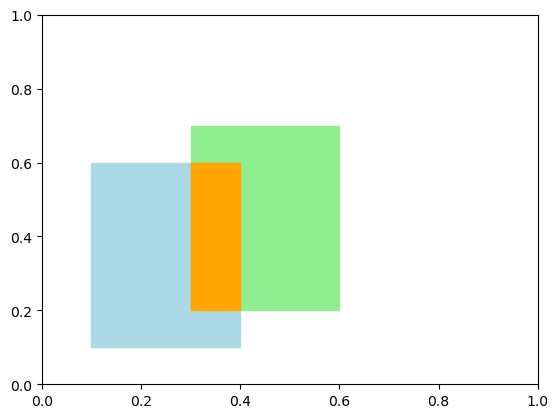

In [3]:
# Create figure and axes
fig, ax = plt.subplots()

# Define rectangle parameters
rect1 = Rectangle((0.1, 0.1), 0.3, 0.5, color='lightblue')
rect2 = Rectangle((0.3, 0.2), 0.3, 0.5, color='lightgreen')

# Calculate intersection coordinates
x_intersection = max(rect1.get_x(), rect2.get_x())
y_intersection = max(rect1.get_y(), rect2.get_y())
width_intersection = min(rect1.get_x() + rect1.get_width(), rect2.get_x() + rect2.get_width()) - x_intersection
height_intersection = min(rect1.get_y() + rect1.get_height(), rect2.get_y() + rect2.get_height()) - y_intersection

# Plot rectangles
ax.add_patch(rect1)
ax.add_patch(rect2)

# Plot intersection
intersection = Rectangle((x_intersection, y_intersection), width_intersection, height_intersection, color='orange')
ax.add_patch(intersection)

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.show()

In [4]:
class Config:
    LEARNING_RATE = 2e-5
    BATCH_SIZE = 16  # 64 in original paper but I don't have that much vram, grad accum?
    WEIGHT_DECAY = 0
    EPOCHS = 500#1000
    NUM_WORKERS = 2
    PIN_MEMORY = True
    LOAD_MODEL = False
    LOAD_MODEL_FILE = "overfit.pth.tar"
    IMG_DIR = "pascalvoc-yolo"
    LABEL_DIR = "pascalvoc-yolo"

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(0)

In [6]:
architecture_config = [
    #kernel size,
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    #list tuples and last int reğresent number of repeats
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [7]:
import timm
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, split_size=7, num_boxes=2, num_classes=20):
        super(Yolov1, self).__init__()
        # Load a pre-trained Vision Transformer model
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.vit.head = nn.Identity()  # Remove the classification head

        # Example dimensions, you need to adjust this based on your specific model
        self.num_features = self.vit.num_features  # The features number of ViT model
        self.S = split_size
        self.B = num_boxes
        self.C = num_classes
        
        # Custom fully connected layers for YOLOv1 output
        self.fcs = self._create_fcs(self.S, self.B, self.C)

    def forward(self, x):
        x = self.vit(x)  # Pass input through the Vision Transformer
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_fcs(self, S, B, C):
        # You might need to adjust this layer to match the output of your ViT model
        return nn.Sequential(
            nn.Linear(self.num_features, 1024),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(1024, S * S * (C + B * 5)),
        )

In [8]:
def test(split_size=7, num_boxes=2, num_classes=20):
  model = Yolov1(split_size=split_size, num_boxes=num_boxes, num_classes=num_classes)
  x = torch.randn((2,3,224,224))
  print(model(x).shape)
  print(model(x))
test(split_size=7, num_boxes=2, num_classes=20)

torch.Size([2, 1470])
tensor([[ 0.0711, -0.1429, -0.0078,  ..., -0.2114, -0.1240, -0.0799],
        [ 0.1064, -0.1603, -0.0519,  ..., -0.2331, -0.1284, -0.1528]],
       grad_fn=<AddmmBackward0>)


In [9]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [10]:
class VOCDataset(torch.utils.data.Dataset):
  def __init__(self, csv_files,img_dir, label_dir, S=7, B=2,C=20,transform= None):
    self.annotations = pd.read_csv(csv_files)#.head(5000)
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.S = S
    self.B = B
    self.C = C
    self.transform = transform
  def __len__(self):
    return len(self.annotations)


  def __getitem__(self, index):
    label_path = os.path.join(self.label_dir,self.annotations.iloc[index, 1] )
    boxes = []
    with open(label_path) as f:
      for label in f.readlines():
        class_label, x,y,width,height = [
            float(x) if float(x) != int(float(x)) else int(x)
            for x in label.replace("\n", "").split()
        ]
        boxes.append([class_label, x,y,width,height])
    img_path = os.path.join(self.img_dir, self.annotations.iloc[index,0])
    image = Image.open(img_path)


    if self.transform:
      boxes = torch.tensor(boxes)
      image, boxes =self.transform(image, boxes)
    label_matrix = torch.zeros(self.S, self.S, self.C + 5*self.B)

    for box in boxes:
      class_label, x,y,width,height = box
      class_label =  int(class_label)
      i,j = int(self.S * y),int(self.S * x)
      x_cell, y_cell = self.S * x - j, self.S * y - i

      width_cell, height_cell  = (width * self.S, height*self.S)
      a = np.array(label_matrix)
      if label_matrix[i,j, 20] == 0:
        label_matrix[i,j, 20] = 1
        box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])

        label_matrix[i,j, 21:25] = box_coordinates
        label_matrix[i,j, class_label] = 1

    a = np.array(label_matrix)
    return image, label_matrix

In [11]:
#200 images
import glob

images_dir = 'pascalvoc-yolo/images'
labels_dir = 'pascalvoc-yolo/labels'

image_paths = glob.glob(os.path.join(images_dir, '*.jpg'))
df = pd.DataFrame({'image_path': image_paths})
df['label_path'] = df['image_path'].apply(lambda x: os.path.join(labels_dir, os.path.basename(x).replace('.jpg', '.txt')))
df['image_path'] = df['image_path'].str.split("/").str[-1]
df['label_path'] = df['label_path'].str.split("/").str[-1]
df.loc[df['image_path'].str.contains("_")==False].head(200).to_csv('200examples.csv', index=False)

In [12]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes
    
transform = Compose([transforms.Resize((224, 224)), 
                     transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = VOCDataset(
        "pascalvoc-yolo/200examples.csv",# if you use train.csv it will take 70 hours
         transform=transform,
         img_dir=Config.IMG_DIR,
         label_dir=Config.LABEL_DIR,
    )

test_dataset = VOCDataset(
        "pascalvoc-yolo/test.csv",
        transform=transform,
        img_dir=Config.IMG_DIR,
        label_dir=Config.LABEL_DIR,
    )

In [13]:
len(train_dataset), len(test_dataset)

(200, 4951)

In [14]:
import time
from tqdm import tqdm

def train_fn(train_loader, model, optimizer, loss_fn, device):
    mean_loss = []

    # Initialize tqdm with total number of epochs
    loop = tqdm(total=len(train_loader)*Config.EPOCHS, position=0, leave=True)

    for epoch in range(Config.EPOCHS):
        epoch_loss = 0.0  # Track the loss for each epoch

        for batch_idx, (x, y) in enumerate(train_loader):
            a = np.array(y)
            x, y = x.to(device), y.to(device)

            # Forward pass
            out = model(x)
            loss = loss_fn(out, y)
            epoch_loss += loss.item()  # Accumulate loss for the epoch

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{Config.EPOCHS}]")
            loop.set_postfix(loss=loss.item())
            loop.update(1)

        mean_loss.append(epoch_loss / len(train_loader))  # Mean loss for the epoch

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{Config.EPOCHS}], Mean loss: {mean_loss[-1]}")

    loop.close()  # Close tqdm bar

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [15]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)


optimizer = optim.Adam(
        model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY
    )


loss_fn = YoloLoss()
if Config.LOAD_MODEL:
    load_checkpoint(torch.load(Config.LOAD_MODEL_FILE), model, optimizer)

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=Config.BATCH_SIZE,
        #num_workers=Config.NUM_WORKERS,
        pin_memory=Config.PIN_MEMORY,
        shuffle=True,
        drop_last=True,
)

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=Config.BATCH_SIZE,
        #num_workers=Config.NUM_WORKERS,
        pin_memory=Config.PIN_MEMORY,
        shuffle=False,
        drop_last=True,
    )

start_time = time.time()
train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
end_time = time.time()

print(f"Training finished in {(end_time - start_time)/60:.2f} minutes")
"""
Notes
* torch compile implementation gives error at the moment
* transfomers vits can be tested
"""

  0%|          | 0/6000 [00:00<?, ?it/s]c:\Users\Evan\anaconda3\envs\pytorch\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(
Epoch [50/500]:  10%|█         | 600/6000 [05:50<57:36,  1.56it/s, loss=14.2]  

Epoch [50/500], Mean loss: 11.758712212244669


Epoch [100/500]:  20%|██        | 1200/6000 [11:45<47:13,  1.69it/s, loss=3.93]

Epoch [100/500], Mean loss: 3.1670835812886557


Epoch [150/500]:  30%|███       | 1800/6000 [17:44<40:18,  1.74it/s, loss=3.35]  

Epoch [150/500], Mean loss: 3.300558586915334


Epoch [200/500]:  40%|████      | 2400/6000 [23:36<34:10,  1.76it/s, loss=3.05] 

Epoch [200/500], Mean loss: 2.5464148819446564


Epoch [250/500]:  50%|█████     | 3000/6000 [29:34<32:48,  1.52it/s, loss=2.78] 

Epoch [250/500], Mean loss: 3.5167860786120095


Epoch [300/500]:  60%|██████    | 3600/6000 [35:25<23:15,  1.72it/s, loss=2.13] 

Epoch [300/500], Mean loss: 1.4968355000019073


Epoch [350/500]:  70%|███████   | 4200/6000 [41:12<17:31,  1.71it/s, loss=1.59] 

Epoch [350/500], Mean loss: 1.4530379871527355


Epoch [400/500]:  80%|████████  | 4800/6000 [46:57<11:17,  1.77it/s, loss=0.77] 

Epoch [400/500], Mean loss: 1.1855845252672832


Epoch [450/500]:  90%|█████████ | 5400/6000 [52:41<05:44,  1.74it/s, loss=1.67] 

Epoch [450/500], Mean loss: 1.6230374872684479


Epoch [500/500]: 100%|██████████| 6000/6000 [58:25<00:00,  1.71it/s, loss=0.604]

Epoch [500/500], Mean loss: 0.4711553653081258
Mean loss was 12.752428562661
Training finished in 58.43 minutes


'\nNotes\n* torch compile implementation gives error at the moment\n* transfomers vits can be tested\n'

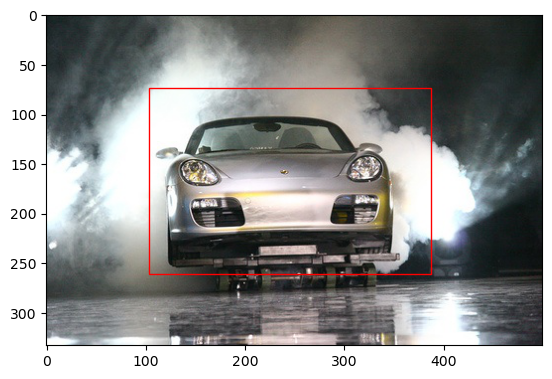

In [29]:
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load the image
image_path = 'pascalvoc-yolo/images/001003.jpg'
image = Image.open(image_path).convert("RGB")

# Define the transform
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match the input dimensions expected by the model
    T.ToTensor(),  # Convert the PIL Image to a tensor
])

# Apply the transform to the image
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
model.eval()  # Set the model to evaluation mode

# Move the model to the appropriate device
model.to(DEVICE)
image_tensor = image_tensor.to(DEVICE)

# Perform prediction
with torch.no_grad():
    predictions = model(image_tensor)

# Convert predictions to bounding boxes format
# This depends on your model's output format; you may need to adjust this
bboxes = cellboxes_to_boxes(predictions, S=7)[0]  # Assuming the first item in the batch

# Filter bounding boxes with NMS
iou_threshold = 0.5
threshold = 0.6  # Confidence threshold
nms_boxes = non_max_suppression(bboxes, iou_threshold, threshold, box_format="midpoint")

# Visualize the results on the original image
plot_image(image, nms_boxes)